### Context#### 
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness
#### 
During the entire course of the pandemic, one of the main problems that healthcare providers have faced is the shortage of medical resources and a proper plan to efficiently distribute them. In these tough times, being able to predict what kind of resource an individual might require at the time of being tested positive or even before that will be of immense help to the authorities as they would be able to procure and arrange for the resources necessary to save the life of that patient.#### 

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not

## Data Preprocessing and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings

from ydata_profiling import ProfileReport

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./Covid Data.csv')
df.shape

(1048575, 21)

In [3]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [4]:
# Converting all columns to lower case character
df.columns = df.columns.str.lower()
df.columns

Index(['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed',
       'pneumonia', 'age', 'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hipertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'clasiffication_final', 'icu'],
      dtype='object')

In [5]:
# The values of 97, 98 and 99 are known to represent missing data
# Replace the values where pregnancy is unknown and isfemale is 0(false) to 0(False)
df.replace({97: pd.NA, 98:pd.NA, 99:pd.NA}, inplace=True)
df.loc[(df['pregnant'].isna()) & (df['sex'] == 2), 'pregnant']= 0

In [6]:
df.isnull().sum()

usmer                        0
medical_unit                 0
sex                          0
patient_type                 0
date_died                    0
intubed                 855869
pneumonia                16003
age                        345
pregnant                  3754
diabetes                  3338
copd                      3003
asthma                    2979
inmsupr                   3404
hipertension              3104
other_disease             5045
cardiovascular            3076
obesity                   3032
renal_chronic             3006
tobacco                   3220
clasiffication_final         0
icu                     856032
dtype: int64

In [7]:
# Check for duplicated data
df.duplicated().any()

True

In [8]:
# Total duplicated rows
df.duplicated().sum()

812074

In [9]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236501 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   usmer                 236501 non-null  int64 
 1   medical_unit          236501 non-null  int64 
 2   sex                   236501 non-null  int64 
 3   patient_type          236501 non-null  int64 
 4   date_died             236501 non-null  object
 5   intubed               131137 non-null  object
 6   pneumonia             229315 non-null  object
 7   age                   236218 non-null  object
 8   pregnant              234547 non-null  object
 9   diabetes              233662 non-null  object
 10  copd                  233973 non-null  object
 11  asthma                233996 non-null  object
 12  inmsupr               233576 non-null  object
 13  hipertension          233882 non-null  object
 14  other_disease         232140 non-null  object
 15  cardiovascular       

In [11]:
df.isna().sum()

usmer                        0
medical_unit                 0
sex                          0
patient_type                 0
date_died                    0
intubed                 105364
pneumonia                 7186
age                        283
pregnant                  1954
diabetes                  2839
copd                      2528
asthma                    2505
inmsupr                   2925
hipertension              2619
other_disease             4361
cardiovascular            2602
obesity                   2553
renal_chronic             2530
tobacco                   2737
clasiffication_final         0
icu                     105513
dtype: int64

In [12]:
# Get categorical_cols to use for EDA
# Categorical_cols are columns besides age since age is continuous
categorical_cols = df.columns.difference(['age'])
categorical_cols

Index(['asthma', 'cardiovascular', 'clasiffication_final', 'copd', 'date_died',
       'diabetes', 'hipertension', 'icu', 'inmsupr', 'intubed', 'medical_unit',
       'obesity', 'other_disease', 'patient_type', 'pneumonia', 'pregnant',
       'renal_chronic', 'sex', 'tobacco', 'usmer'],
      dtype='object')

In [13]:
# clasiffication_final and medical_unit are excluded since they have more than 2 categories
# Replace '2' values as '0' for binary_cols
binary_cols = categorical_cols.difference(['clasiffication_final', 'medical_unit'])
df[binary_cols] = df[binary_cols].replace({2: 0})
df.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,0,1,1,1,03/05/2020,<NA>,1,65,0,0,...,0,0,1,0,0,0,0,0,3,<NA>
1,0,1,0,1,03/06/2020,<NA>,1,72,0,0,...,0,0,1,0,0,1,1,0,5,<NA>
2,0,1,0,0,09/06/2020,1,0,55,0,1,...,0,0,0,0,0,0,0,0,3,0
3,0,1,1,1,12/06/2020,<NA>,0,53,0,0,...,0,0,0,0,0,0,0,0,7,<NA>
4,0,1,0,1,21/06/2020,<NA>,0,68,0,1,...,0,0,1,0,0,0,0,0,3,<NA>


In [14]:
# Summary statistics
df.describe()

,usmer,medical_unit,sex,patient_type,clasiffication_final
count,236501.000000,236501.000000,236501.000000,236501.000000,236501.000000
mean,0.487685,7.633896,0.452459,0.422239,4.781185
std,0.499849,3.661266,0.497736,0.493917,1.897238
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,0.000000,0.000000,3.000000
50%,0.000000,6.000000,0.000000,0.000000,5.000000
75%,1.000000,12.000000,1.000000,1.000000,7.000000
max,1.000000,13.000000,1.000000,1.000000,7.000000


In [15]:
df.drop(['medical_unit'], axis=1, inplace=True)

In [16]:
# Dropping all roes with null values
df.dropna(inplace=True)

In [17]:
# Get the distribution analysis of each categorical features
# Representing the values of categorical columns with 0 and 1 (NO, YES)
# Converting age to age group for detailed analysis
# Converting boolean values to object type for upcoming training

bins = [0, 18, 40, 60, 80, 100, 120]
labels = ['0-17', '18-39', '40-59', '60-79', '80-100', '101-120']

# Use cut to create age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
# Drop the original 'age' column if needed
df.drop(columns=['age'], inplace=True)

df.head()

,usmer,sex,patient_type,date_died,intubed,pneumonia,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,age_group
2,0,0,0,09/06/2020,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,40-59
5,0,1,0,9999-99-99,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,40-59
8,0,1,0,9999-99-99,0,0,0,1,0,0,0,1,0,0,1,0,0,3,0,18-39
9,0,1,0,9999-99-99,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,18-39
11,0,0,0,9999-99-99,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,18-39


In [18]:
# Converting date-died into categorical data where 9999-99-99 is said to be alive
# Create has_died column as boolean and drop date_died column
get_valid_dates = df['date_died'] != '9999-99-99'
df['has_died'] = get_valid_dates.astype(int)
df.drop(columns=['date_died'], inplace=True)
df.head()

,usmer,sex,patient_type,intubed,pneumonia,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,age_group,has_died
2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,40-59,1
5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,40-59,0
8,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,3,0,18-39,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,18-39,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,18-39,0


In [19]:
df.shape

(127643, 20)

In [20]:
# profile = ProfileReport(df, title="Covid Data Profiling Report")# 
# profile

### Summary of the above data cleaning and preprocessing
1. From the data we discover that certain number of people died 

# Exploratory Data Analysis to Identify Relationships

Conducting Exploratory data analysis is an effective way to discover patterns, locate outliers, and show relationships between variables. 
In subsequequent graphical analysis we will explore the relationships between the the variables in relaation to the target variable. 

However, in the subsequent analysis we will graphically understand what might be or determine the cause of a covid 19 patient tested at a different degrees be at high risk of dying. In our case we have multiples of diseases and we know disease is one of the major causes of health deteriorating. Therefore, we will conduct a graphical visualisation using bar chart to compare disease and death rate of patient.

Bar chart is an effective tools against categorical variable making it easy to visualize the relationships between categorical variable. We will be exploring the relationship between in positive occurence of each variables against our target variable.


In [21]:
print(df.columns)
categorical_cols = ['intubed', 'pneumonia', 'pregnant',
       'diabetes', 'copd', 'asthma', 'inmsupr', 'hipertension',
       'other_disease', 'cardiovascular', 'obesity', 'renal_chronic',
       'tobacco', 'icu', 'age_group']
new_df = df[categorical_cols]
target = df['has_died'].astype(str)



Index(['usmer', 'sex', 'patient_type', 'intubed', 'pneumonia', 'pregnant',
       'diabetes', 'copd', 'asthma', 'inmsupr', 'hipertension',
       'other_disease', 'cardiovascular', 'obesity', 'renal_chronic',
       'tobacco', 'clasiffication_final', 'icu', 'age_group', 'has_died'],
      dtype='object')


# Graphical Observations

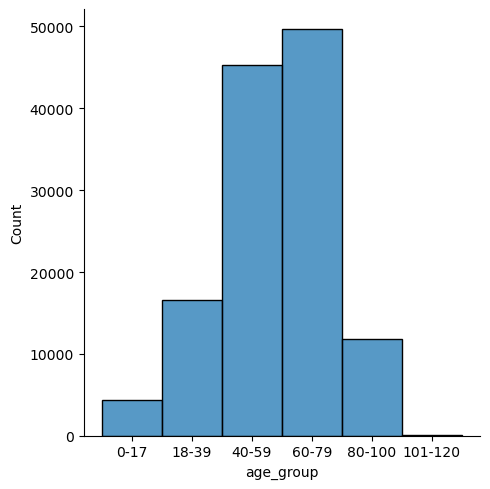

In [22]:
# Plotting the distribution graph of the features
sns.displot(new_df['age_group'])

Target looks like classification


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='has_died'>,
 None,
 array([[<Axes: title={'center': 'intubed'}>,
         <Axes: title={'center': 'clasiffication_final'}>,
         <Axes: title={'center': 'age_group'}>,
         <Axes: title={'center': 'pneumonia'}>,
         <Axes: title={'center': 'sex'}>],
        [<Axes: title={'center': 'usmer'}>,
         <Axes: title={'center': 'tobacco'}>,
         <Axes: title={'center': 'other_disease'}>,
         <Axes: title={'center': 'cardiovascular'}>,
         <Axes: title={'center': 'obesity'}>],
        [<Axes: title={'center': 'diabetes'}>,
         <Axes: title={'center': 'hipertension'}>,
         <Axes: title={'center': 'copd'}>,
         <Axes: title={'center': 'renal_chronic'}>,
         <Axes: title={'center': 'icu'}>]], dtype=object)]

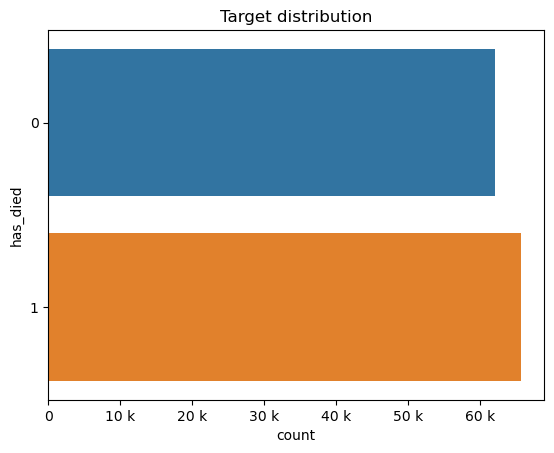

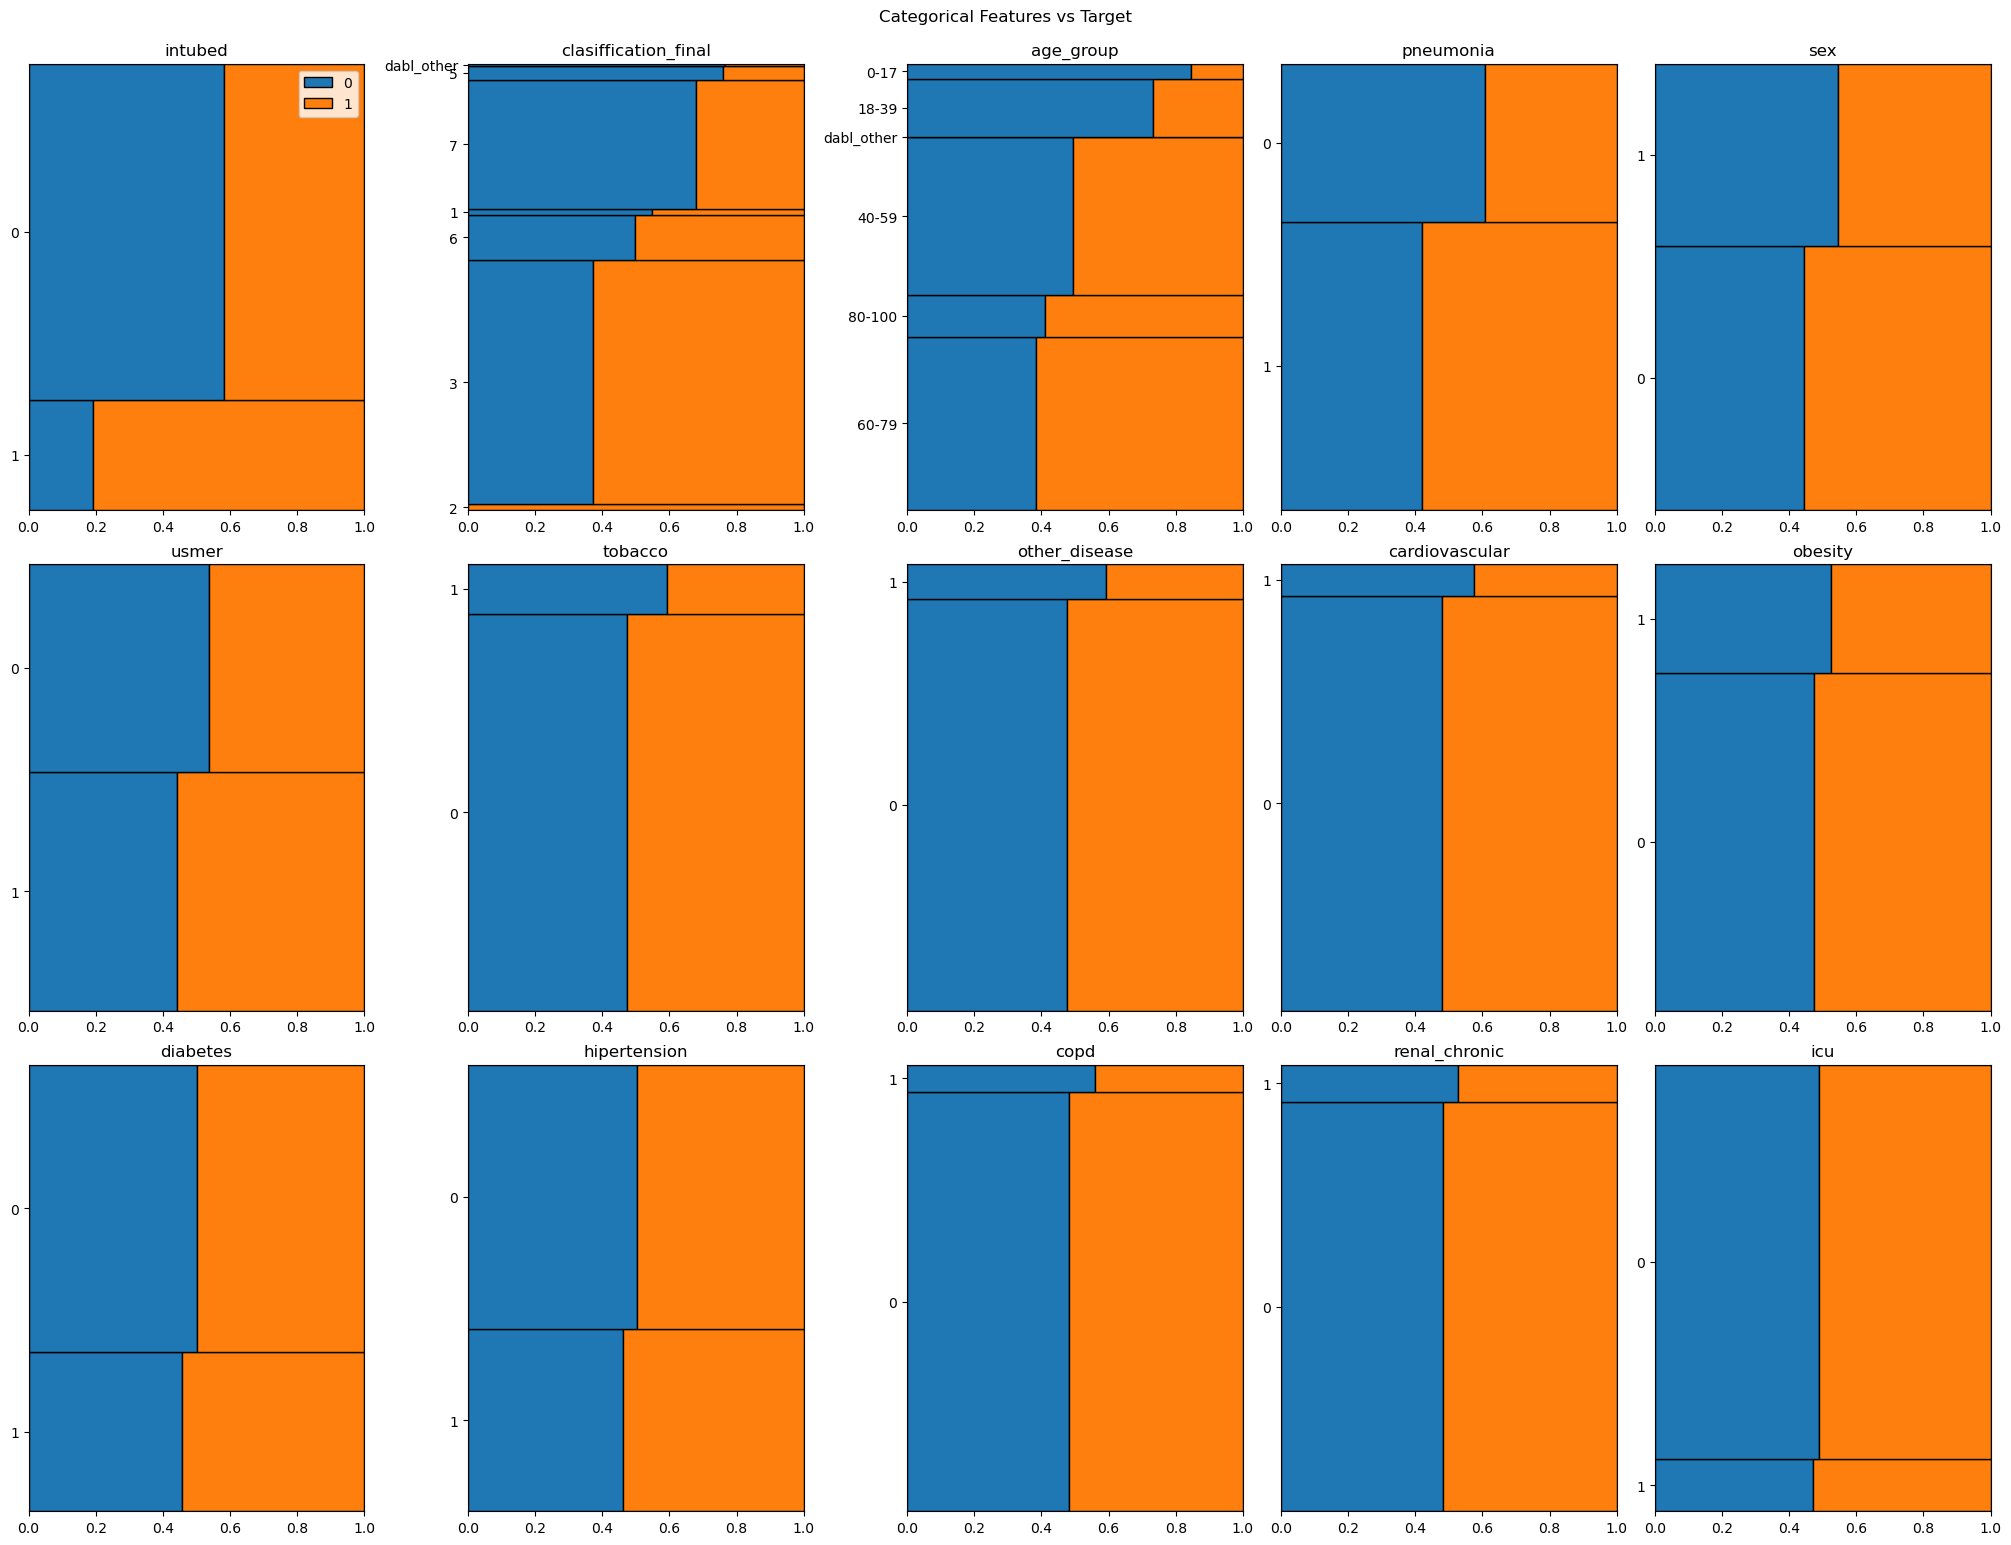

In [23]:
import dabl
dabl.plot(df, target_col='has_died')


### Observation from the above Exploratory Graphs
1. Majority of the patient tested with covid 19 in 3 degrees did not survive.
2. Age is a prime factor in the death of patients which we discover that patients with 60 years and above is likely to die of the virus
3. A patient with Pneumonia diabetes has a slim chance of survival.
4. Putting a patient intube does not determine the survival of that individual
5. USMER treatment of the first, second and third medical does not determine the survival of the patient

## Conculsion
After careful observation from the above data we have come to conclude that.
- Age: the younger people survived the virus while older people did not which may be due to deteriorating in health and weakening in Immune system
- Pnuemonia patients and diabetes patients also have a slim chances of survival

## Splitting data into test set and training set

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(columns=['has_died'])
y = df['has_died']

encoder = pd.get_dummies(X, drop_first=True)
encoder.head()

,usmer,sex,patient_type,clasiffication_final,intubed_1,pneumonia_1,pregnant_1,diabetes_1,copd_1,asthma_1,...,cardiovascular_1,obesity_1,renal_chronic_1,tobacco_1,icu_1,age_group_18-39,age_group_40-59,age_group_60-79,age_group_80-100,age_group_101-120
2,0,0,0,3,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
5,0,1,0,3,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,0,1,0,3,False,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
9,0,1,0,3,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
11,0,0,0,3,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [25]:
# Feature selection method using chi2 for categorical output, categorical input
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(chi2, k=10)

X_new = fs.fit_transform(encoder, y)

# Take the selected features
cols = fs.get_feature_names_out()


# convert selected features into DataFrame
fs_df = pd.DataFrame(X_new, columns=cols)
fs_df.shape

(127643, 10)

# Machine learning module, encoding and model training
#### Imbalanced Dataset Treatment Using SMOTENC Technique
The Scikit-learn library has an extension library called “Imbalanced-learn” which has various methods to handle imbalanced data.

To upsample minority class samples, I use the “Synthetic Minority Over-sampling Technique for Nominal and Continuous” (SMOTENC) techniques in this project. This method is designed for categorical and continuous features to accurately upsample the dataset.

In [26]:
import numpy as np

# importing the SMOTENC object from imblearn library
from imblearn.over_sampling import SMOTENC

# categorical features for SMOTENC technique for categorical features
n_cat_index = np.array(range(1,50))
categorical_features = [0, 1, 2]  # Update with actual indices of categorical features

# creating smote object with SMOTENC class
smote = SMOTENC(categorical_features=categorical_features, random_state=42, n_jobs=True)
X_n, y_n = smote.fit_resample(fs_df, y)

# print the shape of new upsampled dataset
X_n.shape, y.shape

((131190, 10), (127643,))

In [27]:
print(y.value_counts())

has_died
1    65595
0    62048
Name: count, dtype: int64


# Splitting the data into training and test set

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)
numerical_features = df[[col for col in df.columns if col != 'has_died']]

# Training the logistic regression model on the training set

In [29]:
from sklearn.linear_model import LogisticRegression
classifier_r = LogisticRegression(max_iter=1000)
classifier_r.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = classifier_r.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)
classifier_r.score(X_train, y_train)

[[9896 3122]
 [4506 8714]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72     13018
           1       0.74      0.66      0.70     13220

    accuracy                           0.71     26238
   macro avg       0.71      0.71      0.71     26238
weighted avg       0.71      0.71      0.71     26238



0.70494130650202

# Training the Random Forest Classification model on the Training set

In [31]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=42)

In [32]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)

[[9508 3510]
 [3866 9354]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72     13018
           1       0.73      0.71      0.72     13220

    accuracy                           0.72     26238
   macro avg       0.72      0.72      0.72     26238
weighted avg       0.72      0.72      0.72     26238



In [33]:
def feature_coefficients(feature_names: list, feature_coefficients: list):
    """
    Returns dataframe containing the feature coefficients
    
    Args:
        feature_names (list): list of feature names
        feature_coefficients (list): list of coefficients
    Returns:
        df (pd.DataFrame): dataframe containing feature coefficeint values
    """
    df = pd.DataFrame({'feature': feature_names, 'coefficient': feature_coefficients})
    df = df.assign(abs_coef=lambda x: x['coefficient'].abs())
    df = df.sort_values(by='abs_coef', ascending=False)[['feature', 'coefficient']]
    
    return df

In [34]:
feature_names = X_n.columns
coef = list(classifier_r.coef_.flatten())

# top 3 coefficeints (odds ratio)
feature_coefficients(feature_names, coef).sort_values(by='coefficient', ascending=False).iloc[:3]

,feature,coefficient
2,intubed_1,1.638961
3,pneumonia_1,0.477722
9,age_group_60-79,0.462096


## Conclusion


##### Random Forest classification model tends to have more classification report compare to other models. 
## Inferences
1. Intubed: when a patient is in tube, the logs of the patient dying is estimated to increase by 1.6
2. Pneumonia: A pneumonia patient log  of dying is tend to increase by 0.47
3. Age: Patients of 60 years and above log of dying is tend to increase by 0.46

In [35]:
# Train score
classifier.score(X_train, y_train)

0.7168134004116168

### Encoding dataset for development and model deployment

In [36]:
import joblib
from sklearn.preprocessing import OrdinalEncoder

new_feature_df = df[['usmer', 'sex', 'patient_type', 'clasiffication_final',
                             'intubed', 'pneumonia', 'pregnant', 'diabetes', 'copd', 'asthma', 'cardiovascular',
                             'obesity', 'renal_chronic', 'tobacco', 'icu', 'age_group']]

oencoder = OrdinalEncoder()
encoded_df = pd.DataFrame(oencoder.fit_transform(new_feature_df))
encoded_df.columns = new_feature_df.columns

# Save the ordinal encoder object for inference pipeline
joblib.dump(oencoder, 'ordinal_encoder.joblib')

['ordinal_encoder.joblib']